In [ ]:
# For mac OS
# %pip install -U tensorflow==2.17.0 tensorflow-datasets tensorflow-text tensorflow-macos keras==3.4.1 keras-nlp datasets rouge-score
# For Intel mac
# %pip install -U tensorflow==2.17.0 tensorflow-datasets tensorflow-text keras==3.4.1 keras-nlp datasets rouge-score
# For AWS SageMaker
# %pip install -U packaging setuptools
# %pip install -U tensorflow==2.17.0 tensorflow-datasets tensorflow-text keras==3.4.1 keras-nlp datasets rouge-score py7zr

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Utility function to determine where this note is running
import platform

def is_running_on_apple_silicon():
    """
    Determine if this is running on Apple Silicon Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "arm"

def is_running_on_intel_mac():
    """
    Determine if this is running on Intel Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "i386"

# This flag is used for tf.debugging.experimental.enable_dump_debug_info.
# However, this makes 10 times slower.
DEBUGGER_V2 = False

In [3]:
import tensorflow as tf
import keras
import keras_nlp
print("TensorFlow 2.17.0 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

if is_running_on_apple_silicon() or is_running_on_intel_mac():
    FLOAT_TYPE = tf.float32
else:
    """
    # Mixed-precision training
    Deep Learning with Python, Second Edition
    François Chollet

    However, this makes the processing 2.x slower on M2 Apple Silicon.

    Machine | 1 step
    --- | ---
    Intel Mac - fp32 : fp16 | 1 : 1.714
    Apple Silicon M2 (Mac Book Pro) - fp32 : fp16 | 1 : 2.813
    NVIDIA V100 GPU x 1 (ml.p3.2xlarge) - fp32 : fp16 | 1 : 0.875    Intel Mac - fp32 : fp16 | 1 : 1.714
    """
    keras.mixed_precision.set_global_policy("mixed_float16")
    FLOAT_TYPE = tf.float16

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving
import datetime
import time

TensorFlow 2.17.0 is expected. The running version is 2.17.0
Keras 3.4.1 is expected. The running version is 3.5.0
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [4]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

def plot_attention_head(
        in_tokens,
        translated_tokens,
        attention):
    # The model didn't generate `[start]` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

def plot_attention_weights(
        vectorization_layer,
        sentence,
        translated_tokens,
        attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = vectorization_layer.tokenize(in_tokens).to_tensor()
    in_tokens = vectorization_layer.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')
    plt.tight_layout()
    plt.show()

In [5]:
def get_log_dir(now):
    """
    Specify the log directory for the timestamp
    """
    log_dir = "logs/fit/" + now.strftime("%Y%m%d-%H%M%S")
    return log_dir

def get_tensorboard_callback(now):
    """
    Create the TensorBoard callback
    """
    # @see https://www.tensorflow.org/tensorboard/get_started
    log_dir = get_log_dir(now=now)
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    return tensorboard_callback

In [6]:
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace("'", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    """
    Define the custom standardization to remove useless characters.
    """
    input_string = tf.strings.lower(input_string) # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'\s', ' ') # Replace \n, \r, \t, \f into space.
    #input_string = tf.strings.regex_replace(input_string, r"'", ' ') # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'<\/?[^>]*>', '') # html tag
    #input_string = tf.strings.regex_replace(input_string, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    input_string = tf.strings.regex_replace(input_string, r'https?:\/\/.*[\r\n]*', " ") # URL
    # Some symbols are incorrectly used without space.
    input_string = tf.strings.regex_replace(input_string, r"([%s])" % re.escape(strip_chars), r" \1 ")
    input_string = tf.strings.regex_replace(input_string, r'\s\s+', ' ') # Finally, spaces to 1 space
    return input_string

In [7]:
# @see https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr_callbacks = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=0.04,
    cooldown=6,
    min_lr=2e-6, # 5e-4: 0.0005, 2e-5: 0.00002, 2e-6: 0.000002
)

In [8]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [9]:
# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=FLOAT_TYPE)
    mask = tf.cast(mask, dtype=FLOAT_TYPE)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [10]:
def rouge_n(y_true, y_pred, order=2):
    rouge_n = keras_nlp.metrics.RougeN(order=order)
    return rouge_n(y_true, y_pred)

## Dataset

In [11]:
import datasets

def prepare_datasets():
    """
    Get training set, validation set, and test set
    tensorflow_datasets does not work well with the SSL error.
    Therefore, the data is obtained with the Huggingface library and converted to TensorFlow.
    :return: train_ds
    :return: validation_ds
    :return: test_ds
    """
    # How to convert huggingface dataset to tensorflow dataset
    # @see https://huggingface.co/docs/datasets/v1.3.0/torch_tensorflow.html#setting-the-format
    def convert_hf2tf(
            dataset: datasets.DatasetDict,
            split: list[str],
            columns=['article', 'highlights', 'id',]):
        dataset.set_format(
            type='tensorflow',
            columns=columns
        )
        l = []
        for s in split:
            d = dataset[s]
            features = {x: d[x] for x in columns}
            # .batch(32) is not used to show a simple sampled data below with take(1)
            tf_dataset = tf.data.Dataset.from_tensor_slices(features)
            l.append(tf_dataset)
        return tuple(l)
    ds = datasets.load_dataset(
        'Samsung/samsum',
        trust_remote_code=True
    )
    train_ds, validation_ds, test_ds = convert_hf2tf(
        dataset=ds,
        split=['train', 'validation', 'test'],
        columns=['id', 'summary', 'dialogue'],
    )
    return train_ds, validation_ds, test_ds

In [12]:
def prepare_tokenizer(
        vectorization_layer,
        decoder_sequence_length,
        max_tokens=15000):
    """
    Display the plot that indicates the loss and accuracy.
    :param vectorization_layer: obtain vocabulary.
    :param max_tokens: In other words, this is the vocabulary size.
    :param decoder_sequence_length: The sequence length for target.
    """
    vocabulary = vectorization_layer.get_vocabulary()

    target_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=decoder_sequence_length,
    )
    target_vectorization_layer.set_vocabulary(vocabulary)
    return target_vectorization_layer

def build_datasets(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        batch_size,
        decoder_sequence_length):
    start_oov = vectorization_layer(['[start]'])[0][0].numpy().item()
    end_oov = vectorization_layer(['[end]'])[0][0].numpy().item()
    start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=decoder_sequence_length,
        start_value=start_oov,
        end_value=end_oov,
    )
    start_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=decoder_sequence_length,
        start_value=start_oov,
    )
    end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=decoder_sequence_length,
        end_value=end_oov,
    )
    def format_dataset(x):
        summary = vectorization_layer(x['summary'])
        summary = end_packer(summary)
        
        # rows = tf.shape(summary)[0] # rows = batch size
        # summary = summary.to_tensor(shape=(
        #     rows,
        #     decoder_sequence_length
        # ))

        dialogue = vectorization_layer(x['dialogue'])
        dialogue = start_packer(dialogue)
        return (dialogue, ), summary

    train_ds = train_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    if validation_ds is not None:
        validation_ds = validation_ds.batch(batch_size).map(
            format_dataset,
            num_parallel_calls=tf.data.AUTOTUNE
        ).prefetch(tf.data.AUTOTUNE).cache()
    test_ds = test_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    return train_ds, validation_ds, test_ds


## Model

In [13]:
@saving.register_keras_serializable()
class TransformerDecoderModel(keras.Model):
    """
    Transformer model class that contains Transformer Decoder inside.
    :param decoder_tokenizer: tf.keras.layers.TextVectorization object
    :num_decoders: the number of decoders
    :num_heads: the number of heads (Attention mechanism)
    :dropout: the dropout rate
    :transformer_intermediate_dim: the number of dimensions in each decoder
    :normalize_first: Pre-Layer Normalization or Post-Layer Normalization
    :layer_norm_epsilon: the epsilon value in layer normalization components.
    :decoder_vocabulary_size: the number of decoder vocabulary size
    :embedding_dim: the dimension for embedding
    :mask_zero: whether 0 is used the mask value
    :decoder_sequence_length: the length of decoder sequence
    :use_residual: whether residual connections are used outside of the Transformer decoder
    """
    def __init__(
        self,
        decoder_tokenizer,
        num_decoders,
        num_heads,
        dropout,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        decoder_sequence_length,
        use_residual,
        **kwargs):
        super(TransformerDecoderModel, self).__init__(**kwargs)
        self.mask_zero = mask_zero
        self.layer_norm_epsilon = layer_norm_epsilon
        self.use_residual = use_residual
        self.decoders = []
        if isinstance(layer_norm_epsilon, list):
            decoder_layer_norm_epsilons = layer_norm_epsilon
        else:
            decoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_decoders)]

        for i in range(num_decoders):
            self.decoders.append(
                keras_nlp.layers.TransformerDecoder(
                    num_heads=num_heads,
                    dropout=dropout,
                    intermediate_dim=transformer_intermediate_dim,
                    normalize_first=normalize_first,
                    layer_norm_epsilon=decoder_layer_norm_epsilons[i],
                    name=f"decoder_{i}",
                )
            )

        self.decoder_tokenizer = decoder_tokenizer

        self.decoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=decoder_vocabulary_size,
            sequence_length=decoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=mask_zero,
            name="decoder_embed",
        )

        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            name="dense",
        )

    def build(self, input_shape):
        self.decoder_embedding.build(input_shape[0])
        decoder_output_shape = self.decoder_embedding.compute_output_shape(input_shape[0])
        for decoder in self.decoders:
            decoder.build(
                decoder_sequence_shape=decoder_output_shape,
                #encoder_sequence_shape=encoder_output_shape,
            )
            decoder_output_shape = decoder.compute_output_shape(
                decoder_sequence_shape=decoder_output_shape,
            )
        self.dense.build(input_shape=decoder_output_shape)
        self.built = True

    def call(self, inputs, training=False):
        """
        This method defines and represents the calculation graph (tensor flow).
        :training: True, when calculating val_loss and val_acc. Otherwise, False.
        """
        decoder_input = inputs[0]
        decoded = self.decoder_embedding(decoder_input)
        for decoder in self.decoders:
            if self.use_residual and len(self.decoders) > 1:
                residual = decoded
            decoded = decoder(
                decoder_sequence=decoded,
                use_causal_mask=True,
                training=training,
            )
            if self.use_residual and len(self.decoders) > 1:
                decoded = decoded + residual

        output = self.dense(decoded)
        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del output._keras_mask
        except AttributeError:
            pass
        return output

    def get_config(self):
        """
        This method is used to save a model into a file.
        """
        config = super(TransformerDecoderModel, self).get_config().copy()
        config.update({
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "num_decoders": len(self.decoders),
            "num_heads": self.decoders[0].num_heads,
            "dropout" : self.decoders[0].dropout,
            "transformer_intermediate_dim": self.decoders[0].intermediate_dim,
            "normalize_first": self.decoders[0].normalize_first,
            "layer_norm_epsilon": self.layer_norm_epsilon,
            "decoder_vocabulary_size": self.decoder_embedding.vocabulary_size,
            "embedding_dim": self.decoder_embedding.embedding_dim,
            "mask_zero": self.mask_zero,
            "decoder_sequence_length": self.decoder_embedding.sequence_length,
            "use_residual": self.use_residual,
        })
        return config
    @classmethod
    def from_config(cls, config):
        """
        This method is used to build a model from a saved file.
        """
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(
            decoder_tokenizer=decoder_tokenizer,
            **config
        )

# Decode and Predict

In [14]:
import nltk

EXAMPLES = [
    """(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never seriously in doubt once he got the baton safely in hand from Ashmeade, while Gatlin and the United States third leg runner Rakieem Salaam had problems. Gatlin strayed out of his lane as he struggled to get full control of their baton and was never able to get on terms with Bolt. Earlier, Jamaica\'s women underlined their dominance in the sprint events by winning the 4x100m relay gold, anchored by Shelly-Ann Fraser-Pryce, who like Bolt was completing a triple. Their quartet recorded a championship record of 41.29 seconds, well clear of France, who crossed the line in second place in 42.73 seconds. Defending champions, the United States, were initially back in the bronze medal position after losing time on the second handover between Alexandria Anderson and English Gardner, but promoted to silver when France were subsequently disqualified for an illegal handover. The British quartet, who were initially fourth, were promoted to the bronze which eluded their men\'s team. Fraser-Pryce, like Bolt aged 26, became the first woman to achieve three golds in the 100-200 and the relay. In other final action on the last day of the championships, France\'s Teddy Tamgho became the third man to leap over 18m in the triple jump, exceeding the mark by four centimeters to take gold. Germany\'s Christina Obergfoll finally took gold at global level in the women\'s javelin after five previous silvers, while Kenya\'s Asbel Kiprop easily won a tactical men\'s 1500m final. Kiprop\'s compatriot Eunice Jepkoech Sum was a surprise winner of the women\'s 800m. Bolt\'s final dash for golden glory brought the eight-day championship to a rousing finale, but while the hosts topped the medal table from the United States there was criticism of the poor attendances in the Luzhniki Stadium. There was further concern when their pole vault gold medalist Yelena Isinbayeva made controversial remarks in support of Russia\'s new laws, which make "the propagandizing of non-traditional sexual relations among minors" a criminal offense. She later attempted to clarify her comments, but there were renewed calls by gay rights groups for a boycott of the 2014 Winter Games in Sochi, the next major sports event in Russia.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend .""",
    "There are two chickens in the garden.",
    "Two chickens fell into the swimming pool in the garden.",
]

def post_process(text):
    text = text.replace("[start] ", "")
    text = text.replace(" [end]", "")
    sentences = nltk.sent_tokenize(text)
    ss = []
    for sentence in sentences:
        sentence = sentence.capitalize()
        tokens = nltk.tokenize.word_tokenize(text=sentence)
        tagged_tokens = nltk.tag.pos_tag(tokens=tokens)
        result = []
        for i, (token, tag) in enumerate(tagged_tokens):
            if i == 0:  # The first word of the sentence
                result.append(token.capitalize())
            elif tag.startswith('NNP'):  # proper noun
                result.append(token.capitalize())
            else:
                result.append(token.lower())
        s = " ".join(result)
        ss.append(s)
    text = " ".join(ss)
    text = text.replace(" ,", ",")
    text = text.replace(" .", ".")
    # Revert OOV.
    # text = '[start] ' + text + ' [end]'
    return text

def decode_sequence(
        input_sentence,
        model,
        max_sequence_length,
        lookup_table,
        use_post_processing=False):
    """
    Generate summarized text from the input sentence.
    :input_sentence: the original text that is summarized
    :model: the TransformerDecoderModel class model
    :max_sequence_length: the maximum length of the summarized text
    :lookup_table: the table holds token IDs and their actual words
    """
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = decoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = (
            tokenized_input,
            decoder_inputs,
        )
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    text = " ".join(detokenized_output)
    if use_post_processing:
        text = post_process(text=text)
    return text


def predict_main(
        filepath,
        examples,
        decoder_sequence_length,
        use_post_processing=False):
    """
    Generate summarized text with the model file.
    :filepath: the file path specifies the model
    :examples: the list of text that is summarized.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    loaded_model = keras.models.load_model(
        filepath,
        # Just in case, TransformerDecoderModel is specified.
        # However, it does not seem necessary.
        custom_objects={
            "TransformerDecoderModel": TransformerDecoderModel,
        }
    )

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                loaded_model,
                decoder_sequence_length,
                index_lookup_table,
                use_post_processing=use_post_processing,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_model(
        model,
        examples,
        decoder_sequence_length,
        use_post_processing=False):
    """
    Generate summarized text with the model.
    :model: the file path specifies the model
    :examples: the list of text that is summarized.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                model,
                decoder_sequence_length,
                index_lookup_table,
                use_post_processing=use_post_processing,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_dataset(
        model,
        iterable_dataset,
        decoder_sequence_length,
        use_post_processing=False):
    """
    Generate summarized text with the model.
    :model: the file path specifies the model
    :iterable_dataset: the dataset, which is mainly test set, used to generate summarized text.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    y_trues = []
    y_preds = []
    for entry in iterable_dataset:
        text = entry["dialogue"]
        result = decode_sequence(
            text,
            model,
            decoder_sequence_length,
            index_lookup_table,
            use_post_processing=use_post_processing,
        )
        y_true = entry["summary"]
        y_true = y_true.decode('utf-8')
        y_pred = result.replace('[start]', '').replace('[end]', '').strip()
        # print(y_true, '\n\t' , y_pred)
        y_trues.append(y_true)
        y_preds.append(y_pred)
    return y_trues, y_preds

def calculate_rouge_score(y_true, y_pred):
    """
    # RougeN metric
    # @see https://keras.io/api/keras_nlp/metrics/rouge_n/
    """
    rouge_n = keras_nlp.metrics.RougeN(order=2)
    rouge_2_score = rouge_n(y_true, y_pred)
    rouge_n = keras_nlp.metrics.RougeN(order=1)
    rouge_1_score = rouge_n(y_true, y_pred)
    rouge_l = keras_nlp.metrics.RougeL()
    rouge_l_score = rouge_l(y_true, y_pred)
    return rouge_1_score, rouge_2_score, rouge_l_score

## Train

In [15]:
def run_training(
        model,
        train_ds,
        validation_ds,
        optimizer,
        epochs,
        steps_per_epoch,
        now,
        verbose,
        callbacks=[]):
    """
    Run training.
    :train_ds: training set
    :validation_ds: validation set
    :optimizer: optimizer.Optimizer
    :epochs: the number of epochs
    :steps_per_epoch: the number of weight updates in a epoch
    :now: timestamp
    """
    metrics = [
        masked_acc,
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        # This makes predictions be filled with pads.
        #loss="sparse_categorical_crossentropy",
        weighted_metrics=[],
    )
    callbacks.append(get_tensorboard_callback(now=now))
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=verbose,
    )
    return history

In [16]:
def build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        num_decoders,
        num_heads,
        dropout,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        decoder_sequence_length,
        use_residual,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        verbose=1,
        callbacks=[]):
    """
    Build the model with specified parameters.
    :return: model: trained model
    :return: filepath: model file path if it is saved
    :return: history: history object to plot
    """
    now = datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        decoder_sequence_length=decoder_sequence_length,
    )

    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = TransformerDecoderModel(
        decoder_tokenizer=target_vectorization_layer,
        num_decoders=num_decoders,
        num_heads=num_heads,
        dropout=dropout,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=normalize_first,
        layer_norm_epsilon=layer_norm_epsilon,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        decoder_sequence_length=decoder_sequence_length,
        use_residual=use_residual,
    )

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        verbose=verbose,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


***

# Build

In [17]:
ADAPT_BATCH_SIZE = 256

train_ds, validation_ds, test_ds = prepare_datasets()
vectorization_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    # max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    ragged=True,
)
vectorization_layer.adapt(
    train_ds.batch(ADAPT_BATCH_SIZE).map(
        lambda row: '[start] ' + row['summary'] + ' ' + row['dialogue'] + ' [end]',
        num_parallel_calls=tf.data.AUTOTUNE,
    ),
    batch_size=ADAPT_BATCH_SIZE,
)
# Use the maximum size of the dataset. 34219
VOCABULARY_SIZE = len(vectorization_layer.get_vocabulary())

In [18]:
vectorization_layer.get_vocabulary()[:12]

['', '[UNK]', ':', '.', ',', 'i', '?', 'the', 'to', 'you', '!', 'a']

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 70s 542ms/step - loss: 7.5824 - masked_acc: 0.0778 - val_loss: 6.3795 - val_masked_acc: 0.1008 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 536ms/step - loss: 6.2761 - masked_acc: 0.0991 - val_loss: 6.3633 - val_masked_acc: 0.1012 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 61s 528ms/step - loss: 6.1138 - masked_acc: 0.1019 - val_loss: 6.4112 - val_masked_acc: 0.0987 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 540ms/step - loss: 5.8830 - masked_acc: 0.1085 - val_loss: 6.4858 - val_masked_acc: 0.0978 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 536ms/step - loss: 5.6204 - masked_acc: 0.1176 - val_loss: 6.5949 - val_masked_acc: 0.0948 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 543ms/step - loss: 5.3743 - masked_acc: 0.1283 - val_loss: 6.7258 - val_masked_acc: 0.0941 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 54

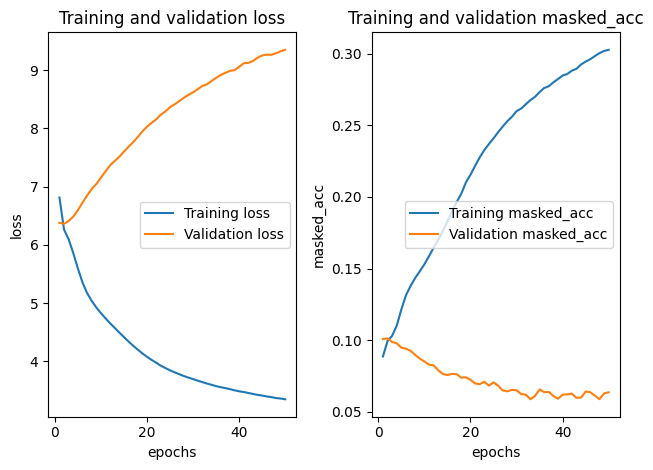

best_epoch is 2
Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 523ms/step - loss: 7.5374 - masked_acc: 0.0797 - learning_rate: 0.0010
Epoch 2/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 65s 528ms/step - loss: 6.2731 - masked_acc: 0.0990 - learning_rate: 0.0010
Saving to model/summarization_model_2024-09-05_14-56-48.keras
Successfully saved model to model/summarization_model_2024-09-05_14-56-48.keras


In [19]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
# ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
# DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
DECODER_SEQUENCE_LENGTH = 128
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-3,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

In [20]:
_, _, tds = build_datasets(
    train_ds=train_ds,
    validation_ds=validation_ds,
    test_ds=test_ds,
    vectorization_layer=vectorization_layer,
    batch_size=128,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
model.evaluate(tds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - loss: 6.2454 - masked_acc: 0.1002


[6.263918876647949, 0.10003809630870819]

In [21]:
y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18329503>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.14508481>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.14491516>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.009834516>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0066961055>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.007009415>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.15025237>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.119945236>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.11926444>}


In [22]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ["Hannah is judy to upload fisherman 's the will.... Minutes.. She it 's.. She she.....",
  "Eric 's and not ed john that lars told the ed pub. Princess. Daniel. Their to prefer only. Much. Quality.. Churches they expensive. Reunion. Priced avid...",
  'Charlotte and to to lend. With.... Cook.',
  'Will will come will buy to korea for grigio. Dinner tonight. Tonight dinner...',
  "Ollie, sandra 's to ollie 